In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
%matplotlib inline

from keras.applications.vgg16 import preprocess_input 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16prenormalized import VGG16prenormalized
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
from keras import applications

input_img = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))
print(input_img)

# model = VGG16(weights='imagenet', input_tensor=input_img)
model = VGG16prenormalized(weights='imagenet', input_tensor=input_img)

Tensor("Placeholder:0", shape=(?, 224, 224, 3), dtype=float32)


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
img_width = 224
img_height = 224

# input_img = model.input
# print(input_img)

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

for key, val in layer_dict.items():
    print(key + ": " + str(val))

input_1: <keras.engine.topology.InputLayer object at 0x7f59845b3978>
block1_conv1: <keras.layers.convolutional.Conv2D object at 0x7f59845b3710>
block1_conv2: <keras.layers.convolutional.Conv2D object at 0x7f59845b3908>
block1_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f5984559cc0>
block2_conv1: <keras.layers.convolutional.Conv2D object at 0x7f598456df98>
block2_conv2: <keras.layers.convolutional.Conv2D object at 0x7f59845126a0>
block2_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f5984526eb8>
block3_conv1: <keras.layers.convolutional.Conv2D object at 0x7f59845358d0>
block3_conv2: <keras.layers.convolutional.Conv2D object at 0x7f59844c8da0>
block3_conv3: <keras.layers.convolutional.Conv2D object at 0x7f59844eccc0>
block3_pool: <keras.layers.pooling.MaxPooling2D object at 0x7f59844fd5c0>
block4_conv1: <keras.layers.convolutional.Conv2D object at 0x7f59844a0898>
block4_conv2: <keras.layers.convolutional.Conv2D object at 0x7f59844b3c18>
block4_conv3: <keras.layers.convol

## get the image example

(1, 224, 224, 3)
float32


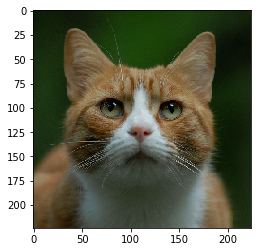

In [5]:
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(x.shape)
print(x.dtype)
plt.imshow(img)

## how to get prenormalized classification loss to improve performance

In [6]:
from keras import backend as K

def get_prediction(layer_dict, instance):
    classification_output = layer_dict["predictions"].output
    return classification_output[instance]

def get_classification_loss(layer_dict, instance, index):
    classification_output = layer_dict["predictions"].output
    return classification_output[instance][index]

pred = get_prediction(layer_dict, 0)
index = np.argmax(pred)

loss = get_classification_loss(layer_dict, 0, index)

In [7]:
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

print(grads)

Tensor("truediv:0", shape=(?, 224, 224, 3), dtype=float32)


In [13]:
sess = tf.InteractiveSession()
K.set_session(sess)

init_op = tf.global_variables_initializer()
sess.run(init_op)

with sess.as_default():
    prediction, saliency_map = sess.run([pred, grads], feed_dict={input_img: x})

FailedPreconditionError: Attempting to use uninitialized value block1_conv1/kernel
	 [[Node: block1_conv1/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@block1_conv1/kernel"], _device="/job:localhost/replica:0/task:0/cpu:0"](block1_conv1/kernel)]]

Caused by op 'block1_conv1/kernel/read', defined at:
  File "/home/justin-y/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/justin-y/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-7e5d99413940>", line 7, in <module>
    model = VGG16prenormalized(weights='imagenet', input_tensor=input_img)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16prenormalized.py", line 111, in VGG16prenormalized
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 558, in __call__
    self.build(input_shapes[0])
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 134, in build
    constraint=self.kernel_constraint)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 317, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 316, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1338, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/justin-y/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value block1_conv1/kernel
	 [[Node: block1_conv1/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@block1_conv1/kernel"], _device="/job:localhost/replica:0/task:0/cpu:0"](block1_conv1/kernel)]]


In [9]:
print(prediction.shape)
print(np.argmax(prediction))
print(prediction)

(1000,)
854
[ -2.33244956e-01  -2.53646761e-01   2.00213641e-01   1.31239980e-01
  -1.86374381e-01   2.57020444e-01   1.70629144e-01  -1.19977795e-01
  -2.69514993e-02  -1.34324878e-01  -1.12960175e-01   2.48032525e-01
   1.28977731e-01   1.69036873e-02  -1.17685758e-01   6.31363690e-02
   1.71366557e-01  -2.99925834e-01  -2.75212437e-01  -1.24736421e-01
   1.84876770e-02  -1.31969959e-01   3.60047594e-02   9.14495140e-02
  -1.00905053e-01   1.17487505e-01   3.36425193e-02  -7.79260471e-02
  -1.34117857e-01   3.47729512e-02  -3.75495777e-02   4.94752415e-02
  -2.18500614e-01   1.47837594e-01   1.20040290e-01   2.29840398e-01
  -2.51017630e-01   9.85210091e-02  -1.31745234e-01  -1.17458120e-01
   1.68813020e-02   5.34052886e-02   1.86416924e-01  -1.68958947e-01
  -1.24066368e-01   3.18966061e-02   2.14933902e-01   1.08062997e-01
   6.27447069e-02  -1.77480698e-01  -7.99202025e-02  -7.15803504e-02
   3.15085620e-01   5.08003011e-02   2.56856233e-01   5.14458977e-02
   8.15502778e-02   1.

(1, 224, 224, 3)
[[[[ -2.91607482e-03   3.66221182e-02   2.04727408e-02]
   [  1.25950556e-02   3.58505733e-02   2.72344667e-02]
   [ -6.92065731e-02  -2.98552904e-02   9.42044556e-02]
   ..., 
   [ -3.66021097e-02   5.46143018e-02   1.05618192e-02]
   [  1.31772039e-02  -3.30327228e-02   8.00254103e-03]
   [ -9.99168307e-03  -1.55881774e-02   2.61603054e-02]]

  [[  1.03840739e-01  -2.87825949e-02   6.13430254e-02]
   [  5.72695620e-02   4.58198935e-02   1.23497449e-01]
   [  5.19215455e-03  -8.89194980e-02   6.56694099e-02]
   ..., 
   [ -1.35499626e-01  -7.80981183e-02  -1.12064309e-01]
   [ -5.60016930e-02   9.30760801e-02   2.72818040e-02]
   [  5.15457690e-02  -6.21681660e-03  -5.07398024e-02]]

  [[  6.12664670e-02   3.13693807e-02  -2.69895829e-02]
   [  1.76159516e-02   1.48310401e-02  -1.45792156e-01]
   [  5.73886670e-02   3.70799229e-02  -2.94639971e-02]
   ..., 
   [ -3.20414118e-02  -9.41830352e-02  -5.84449153e-04]
   [ -2.47774124e-02  -1.40981168e-01  -1.44732028e-01]


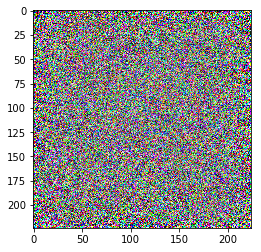

In [10]:
print(saliency_map.shape)
print(saliency_map)
plt.imshow(saliency_map[0])

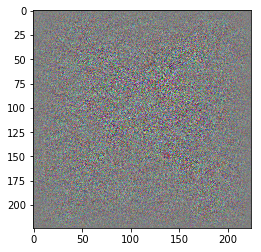

In [12]:
from scipy.misc import imsave
from matplotlib import pyplot as plt
%matplotlib inline 

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5    # center to 0.5 for the [0, 1] interval
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = saliency_map[0]
img = deprocess_image(img)
plt.imshow(img)